In [215]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import math

In [216]:
cities=pd.read_csv("C://Users//Malo//Documents//1A//stage//cities.csv")
providers=pd.read_csv("C://Users//Malo//Documents//1A//stage//providers.csv")
stations=pd.read_csv("C://Users//Malo//Documents//1A//stage//stations.csv")
ticket_data=pd.read_csv("C://Users//Malo//Documents//1A//stage//ticket_data.csv")

In [217]:
%matplotlib inline

On commence par se faire une idée des colonnes des tables.

In [218]:
ticket_data.head()
#cities.head()
#stations.head()
#providers.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


In [248]:
min(ticket_data.price_in_cents),ticket_data.price_in_cents.mean(),max(ticket_data.price_in_cents)

(300, 4382.711061374178, 38550)

Les prix des trajets vont de 3€ à 385€ avec une moyenne à 44€.

In [224]:
def transforme(date):#transforme les dates de ticket_data en dates standard
    heure = str(int(date[11:13])+int(date[20:]))
    return date[:11] + heure + date[13:19]
transforme(ticket_data.loc[1,"departure_ts"])

'2017-10-13 13:05:00'

In [225]:
def duree(i):#calcule la duree en secondes du ticket i avec les dates de depart et d'arrivee
    b = transforme(ticket_data.loc[i,"departure_ts"])
    a = transforme(ticket_data.loc[i,"arrival_ts"])
    start = datetime.datetime.strptime(a, '%Y-%m-%d %H:%M:%S')
    ends = datetime.datetime.strptime(b, '%Y-%m-%d %H:%M:%S')
    diff = relativedelta(start, ends)
    return ((( diff.days*24 + diff.hours)*60 + diff.minutes)*60 + diff.seconds)
duree(1)

64200

On peut donc rajouter la colonne durée à la table ticket_data.

In [226]:
ticket_data["duree"] = pd.Series([duree(i) for i in range(len(ticket_data))])
ticket_data.head()

On regroupe les données par trajet, pour ce faire je définis un trajet par ses villes de départ et d'arrivée.
Je me rends compte après avoir terminé mon travail que ce n'est pas forcément ce qui était attendu mais c'est tout de même intéressant.

In [228]:
gr1=ticket_data.groupby(['o_city','d_city'])
gr1.mean().head()

id      company    o_station    d_station  \
o_city d_city                                                        
5      23      6.852890e+06  8376.000000   562.000000   269.000000   
6      227     6.849908e+06  8378.000000  3653.000000   575.000000   
       504     6.812632e+06  6146.500000  1414.846154  1211.846154   
       628     6.821602e+06  4192.000000    16.000000  8051.250000   
       845     6.855433e+06  8384.940299  3653.000000   527.000000   

               price_in_cents         duree  
o_city d_city                                
5      23        20320.000000  37128.000000  
6      227       11755.000000  49350.000000  
       504        4042.666667  29844.000000  
       628        2797.500000  43800.000000  
       845         864.626866   4794.626866

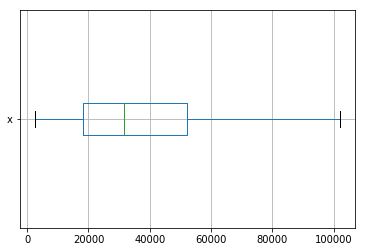

In [249]:
pd.DataFrame.boxplot(gr1.mean()["duree"], vert = False, showfliers = False )#répartition des durées

De nombreuses valeurs extrêmes semblent tirer la moyenne vers le haut. (option showfliers). Par ailleurs on pourrait déjà transformer la colonne durée pour la rendre plus lisible mais cela empêcherait les calculs dessus.

In [244]:
def heures(n):#transforme un nombre de secondes en heures et minutes
    return "%d h %d" % (n//3600,n%3600//60)
heures(1226900)

'340 h 48'

In [231]:
heures(gr1.mean()["duree"].mean())
#duree moyenne par trajet : 11h42, probablement pas représentative.

'11 h 42'

In [232]:
heures(gr1.mean()["duree"].min()),heures(gr1.mean()["duree"].median()),heures(gr1.mean()["duree"].max())
#durees min, mediane et max par trajet : 44min, 8h47 et 340h48 
#le maximum parait aberrant ils serait intéressant de comprendre d'où il sort

('0 h 44', '8 h 47', '340 h 48')

Pour la durée par trajet j'ai considéré qu'un trajet se définissait par la ville de départ et la ville d'arrivée, il est tout a fait possible de remplacer ville par station mais ça ne changera en théorie pas grand chose aux durées.

In [233]:
def distance(i,j):#renvoie la distance en km entre les villes i et j
    if i < 8040 and j < 8040 : 
        lat1 = cities.loc[i,"latitude"]*math.pi/180
        lat2 = cities.loc[j,"latitude"]*math.pi/180
        long1 = cities.loc[i,"longitude"]*math.pi/180
        long2 = cities.loc[j,"longitude"]*math.pi/180
        #latitudes et longitudes du depart et de l'arrivee en radians
        return 6378 * (math.pi/2 - math.asin(math.sin(lat2) * math.sin(lat1) + math.cos(long2 - long1) * math.cos(lat2) * math.cos(lat1)))
    else : return -1 #car certaines villes ne sont pas dans la base
i,j=1,2
distance(i,j),cities.loc[i,"unique_name"],cities.loc[j,"unique_name"]
#815 km entre barcelone et bale, ça semble realiste par rapport aux 1052km que
#donne google maps en voiture. l'important est de pouvoir faire plusieurs groupes
# de trajets selon les distances entre les villes

(814.798860900272, 'barcelona', 'basel')

on rajoute la distance de chaque ticket à la ticket_data, et on joint à providers pour avoir le type de transport.

In [245]:
ticket_data["distance"] = pd.Series([ distance(ticket_data.loc[i,"o_city"], ticket_data.loc[i,"d_city"]) for i in range(len(ticket_data))])

In [246]:
table = ticket_data.merge(providers, left_on = "company", right_on = "id")
table.head()

,id_x,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,...,id_y,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,...,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
1,6795030,8385,NaN,NaN,2017-10-06 05:30:00+00,2017-10-06 08:30:00+00,1800,2017-10-01 01:03:18.948+00,NaN,NaN,...,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
2,6795031,8385,NaN,NaN,2017-10-06 07:00:42+00,2017-10-06 09:30:42+00,2150,2017-10-01 01:03:18.948+00,NaN,NaN,...,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
3,6795032,8385,NaN,NaN,2017-10-06 07:10:00+00,2017-10-06 09:40:00+00,1700,2017-10-01 01:03:18.948+00,NaN,NaN,...,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
4,6795033,8385,NaN,NaN,2017-10-06 10:00:00+00,2017-10-06 12:50:00+00,1700,2017-10-01 01:03:18.948+00,NaN,NaN,...,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling


In [236]:
providers["transport_type"].drop_duplicates()
#il y a 4 moyens de transport en tout dans la base

0             bus
5             car
208         train
223    carpooling
Name: transport_type, dtype: object

In [237]:
providers.loc[providers["transport_type"] == 'car']
#il y a un seul trajet en voiture dans la base, on n'en tient pas compte

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
5,14,6,NaN,driivme,DriiveMe,False,False,False,False,car


Ici on calcule les moyennes des variables prix et durée pour chacune des 4 catégories de distance.

In [250]:
t0 = table.loc[table["distance"].between(0,200) ].groupby("transport_type").mean()[["price_in_cents", "duree"]]
t1 = table.loc[table["distance"].between(200,800) ].groupby("transport_type").mean()[["price_in_cents", "duree"]]
t2 = table.loc[table["distance"].between(800,2000) ].groupby("transport_type").mean()[["price_in_cents", "duree"]]
t3 = table.loc[table["distance"] >=2000 ].groupby("transport_type").mean()[["price_in_cents", "duree"]]

On rassemble le tout sur une seule table :

In [251]:
pd.concat([t0,t1,t2,t3],axis = 1)

,price_in_cents,duree,price_in_cents,duree,price_in_cents,duree,price_in_cents,duree
transport_type,,,,,,,,
bus,3406.552795,56649.968944,3690.366259,57912.807092,3631.394836,54682.474449,4060.615385,79196.307692
carpooling,3763.344316,20329.324547,2764.847444,14833.063419,2649.441879,14350.805687,2289.880952,13064.285714
train,8561.905312,29333.279446,9072.670257,27982.542190,8339.952320,25169.668566,3435.764706,18362.117647


Les résultats ne semblent pas correspondre à ce qu'on attend car les prix décroissent avec la distance pour le covoiturage et pour le train. Les durées ne semblent pas correspondre non plus à ce qu'on attend mais le fait que beaucoup de trajets présentent des escale peut grandement fausser les résultats.
La fonction distance ne semble pas être en cause, sa formule n'est pas excessivement compliquée et sur quelques exemples elle a l'air de fournir des résultats attendus. Cela vient peut-être de la base elle même.